# 1. 초기화
import lots of modules and set up filters regarding raw data

In [2]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from matplotlib import font_manager, rc

rc('font', family='AppleGothic')
matplotlib.rcParams['axes.unicode_minus'] = False   

column_filter = ['배송자휴대전화번호', 'T기프트배송자휴대전화번호', '주문번호', '주문일', '취소일', '결제일', '개통일', '배송일', '모델명', '가입유형', '약정프로그램', '요금제', '무약정Plan선택여부', 
                        '결제방법', '배송방법', '대리점', '주문유형', '쿠폰여부', '지인(추천인)코드', '개통일자', '센터명', '모바일구매여부', '상품구분(맞춤/패키지)', 
                        '서비스관리번호', 'TG상태값', '주문구분', '상담사소속', '대리점코드(중분류)', '외부유입경로', '약정구분', '포인트결제', '동의방법', 
                        '뉴보상기변 쓰던폰반납여부', '오늘보상 신청여부', '오늘보상 수거상태', '클럽기변 신청서 상태', 'T 갤럭시 클럽', '클럽기변 단말기할부금 면제금액', 
                        '대리점명', '매장명', 'D코드', '발송일']

# 개별 데이터를 상반부와 하반부를 합쳐서 생성

In [3]:
# 기준이 되는 24일 ars 인입 고객 정보 로딩 - 나이 연령 정보 포함됨
customer_24 = pd.DataFrame(pd.read_csv('./access_nums_age_sex.csv'),columns=['전화번호', '나이', '성별'])
customer_24['나이'] = pd.to_numeric (customer_24['나이'], errors = 'coerce')
customer_24_drop_na = customer_24.dropna (axis=0)
index_names = customer_24_drop_na[ customer_24_drop_na['성별'] == '#' ].index

customer_24_drop_na.drop(index_names, inplace=True)
#display(customer_24_drop_na)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## 8월 24일 상담센터 인입고객 성별 비율 계산 및 시각화

In [4]:
## 24일 인입된 데이터에 대해서 성별로 정리해서 개수를 세도록 한다.
pivot_sex = pd.pivot_table(customer_24_drop_na, index="성별", values=['전화번호'], aggfunc='count')
display(pivot_sex)


,전화번호
성별,
남,5105
여,3438


<AxesSubplot:ylabel='전화번호'>

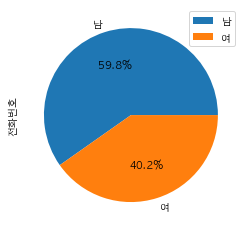

In [5]:
pivot_sex.plot.pie(y="전화번호", autopct='%1.1f%%')

### 위 차트 상으로 남자가 비중이 높다고 볼 수 있지만, 이 내용만으로 유의미한 결론이 나오지 않는다. 오히려, 성별과 나이대를 계산 hitmap을 그리도록 하자

In [6]:
## 히트맵 계산을 위해서, 나이대를 10 살 단위 기준으로 데이터를 정형화 하도록 한다.
## 이를 위해서 기존 데이터에 신규 칼럼 - "연령대" 을 추가하도록 하자.

age_band_width = 10
customer_24_drop_na['나이대'] = customer_24_drop_na['나이'].apply (lambda x: int(x/age_band_width) * age_band_width)
#customer_24_drop_na.head()

pivot_sex_age = pd.pivot_table(customer_24_drop_na, index="성별", columns = ["나이대"], values=['전화번호'], aggfunc='count')
display(pivot_sex_age)

/var/folders/zd/6h6t42ws54b0r4flr83gbx_40000gn/T/ipykernel_3531/4061808374.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_24_drop_na['나이대'] = customer_24_drop_na['나이'].apply (lambda x: int(x/age_band_width) * age_band_width)


전화번호                                                             
나이대   0     10      20      30      40     50     60    70    80   90
성별                                                                   
남    5.0  42.0  1058.0  1668.0  1382.0  660.0  219.0  62.0   9.0  NaN
여    5.0  21.0   760.0  1243.0   857.0  330.0  153.0  51.0  17.0  1.0

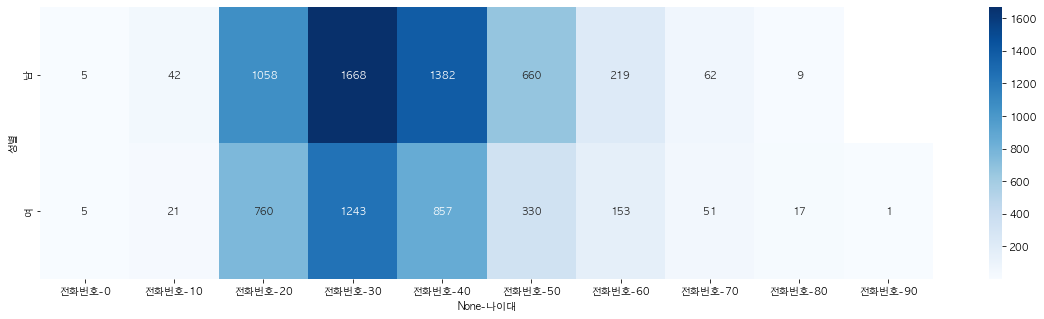

In [7]:
fig = plt.figure(figsize=(20,5))
fig.set_facecolor('white')
 
sns.heatmap(pivot_sex_age, cmap='Blues', annot=True, fmt=".0f")
plt.show()

## 28일 하루 기준으로 상담센터에 전화를 한 고객의 나이 및 성별에 대해서는 다음과 같이 정리 가능
* 상대적으로 여자 보다 남자가 좀 더 전화를 통해서 예판 참여 후 상담센터에 전화를 걸었다.
* 분포 자체는 남성/여성 모두에 있어서 30대가 가장 높은 비중으로 전화로 연결을 많이 했다.

위와 같은 상담센터 이용에 있어서 성별, 나이별 차이는 현재 대상 데이터가 예판 대상 장비와 연관이 있어서, 일반적이지는 않다라고 판단이 가능.

# 실제 위 분포의 특이성을 확인하기 위해선, **전체 갤럭시 폴더블 예판 참가자 분포와 차이가 있는지 분석이 필요**

# 예판 시점에 상담센터에 전화를 한 고객 특성을 분석하자. 우리는 상담센터에 전화를 건 사람들이 가지고 있는 특성이 궁금하다. 
* 예를 들어서 어떤 특정 요금제를 사용하는 사람들인지 아니면 어떤 개통 상 특이 사항이 있는 고객들인지?
* 특정 가입 채널 분포가 더 높은지 이것도 아니면, 가입 단말이 특이 하던지?
* 이러한 관점들에 대해서 실제 데이터를 기준으로 검증을 해나가고자 한다.

# 관련 데이터 준비 단계 - 원 주문 데이터와 접근자 핸폰 정보를 하나로 구성

## 고객별 주문 데이터를 준비 - orders

In [8]:
# 모바일 주문 정보 로딩 
mobile_order_1 = pd.DataFrame (pd.read_csv('./1_m.csv'), columns=column_filter)
mobile_order_2 = pd.DataFrame (pd.read_csv('./2_m.csv'), columns=column_filter)
mobile_orders = pd.concat([mobile_order_1, mobile_order_2], ignore_index=True, axis=0)
mobile_orders.reset_index(drop=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (40,48,108) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (11,40,48,53,54,55,56,117,118,119,120,121) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,배송자휴대전화번호,T기프트배송자휴대전화번호,주문번호,주문일,취소일,결제일,개통일,배송일,모델명,가입유형,...,뉴보상기변 쓰던폰반납여부,오늘보상 신청여부,오늘보상 수거상태,클럽기변 신청서 상태,T 갤럭시 클럽,클럽기변 단말기할부금 면제금액,대리점명,매장명,D코드,발송일
0,1033542025.0,NaN,210815569865/20210815235650624,2021-08-15 23:35:29,NaN,NaN,2021-08-19,NaN,SM-G988N_256GA,기기변경,...,N,미신청,NaN,미신청,NaN,NaN,NaN,NaN,NaN,NaN
1,1053387519.0,1053387519.0,210815569832,2021-08-15 23:19:53,2021-08-16 14:42:55,2021-08-15 23:19:53,NaN,NaN,IPHONE_12_PRO_128GB,기기변경,...,N,미신청,NaN,미신청,NaN,NaN,NaN,NaN,NaN,NaN
2,1091826959.0,1091826959.0,210815569822,2021-08-15 23:14:09,NaN,2021-08-15 23:14:09,2021-08-18,2021-08-18 10:14:00,IPHONE_12_128GB,기기변경,...,N,미신청,NaN,미신청,NaN,NaN,NaN,NaN,NaN,2021-08-17
3,1040536924.0,1040536924.0,210815569799,2021-08-15 23:05:21,2021-08-16 14:53:46,2021-08-15 23:05:21,NaN,NaN,IPHONE_12_MINI_256GGR,기기변경,...,N,미신청,NaN,미신청,NaN,NaN,NaN,NaN,NaN,NaN
4,1044551511.0,1044551511.0,210815569790,2021-08-15 23:03:29,2021-08-15 23:18:16,2021-08-15 23:03:29,NaN,NaN,SM-G998N_256GS,기기변경,...,N,미신청,NaN,미신청,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69714,1085198734,1085198734.0,210816569996,2021-08-16 00:38:16,2021-08-16 14:13:07,2021-08-16 00:38:16,NaN,NaN,IPHONE_12_128GW,기기변경,...,N,미신청,NaN,미신청,NaN,NaN,NaN,NaN,NaN,NaN
69715,1050659647,1050659647.0,210816569991,2021-08-16 00:30:55,NaN,2021-08-16 00:30:55,2021-08-19,2021-08-18 14:46:00,IPHONE_12_PRO_128GG,기기변경,...,N,미신청,NaN,미신청,NaN,NaN,NaN,NaN,NaN,2021-08-17
69716,1044514776,1051764776.0,210816569933,2021-08-16 00:06:57,NaN,2021-08-16 00:06:57,2021-08-19,2021-08-18 17:24:00,OMD XIAOMI REDMI NOTE 10 PRO,기기변경,...,N,미신청,NaN,미신청,NaN,NaN,NaN,NaN,NaN,2021-08-17
69717,1041103858,1041103858.0,210816569931,2021-08-16 00:05:39,2021-08-16 00:06:35,2021-08-16 00:05:39,NaN,NaN,SM-G998N_256G,기기변경,...,N,신청,신청,미신청,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# 바로픽업 정보들 로딩
pickup_order_1 = pd.DataFrame (pd.read_csv('./1_b.csv'), columns=column_filter)
pickup_order_2 = pd.DataFrame (pd.read_csv('./2_b.csv'), columns=column_filter)
pickup_orders = pd.concat([pickup_order_1, pickup_order_2], ignore_index=True, axis=0)
pickup_orders.reset_index(drop=True)

,배송자휴대전화번호,T기프트배송자휴대전화번호,주문번호,주문일,취소일,결제일,개통일,배송일,모델명,가입유형,...,뉴보상기변 쓰던폰반납여부,오늘보상 신청여부,오늘보상 수거상태,클럽기변 신청서 상태,T 갤럭시 클럽,클럽기변 단말기할부금 면제금액,대리점명,매장명,D코드,발송일
0,NaN,1.071245e+09,210815569889,2021-08-15 23:50:18,NaN,2021-08-15 23:50:18,NaN,NaN,SM-G991N,기기변경,...,N,NaN,NaN,미신청,NaN,NaN,PS&M,PS&M (수유점),NaN,NaN
1,NaN,1.093664e+09,210815569871,2021-08-15 23:43:42,NaN,2021-08-15 23:43:42,NaN,NaN,IPHONE7_128GB,기기변경,...,N,NaN,NaN,미신청,NaN,NaN,이안,이안대리점 신림역점,NaN,NaN
2,NaN,1.063651e+09,210815569845,2021-08-15 23:31:14,NaN,2021-08-15 23:31:14,NaN,NaN,IPHONE_11_PRO_256GM,기기변경,...,N,NaN,NaN,미신청,NaN,NaN,PS&M,PS&M (천안신불당점),NaN,NaN
3,NaN,1.045949e+09,210815569834,2021-08-15 23:24:07,NaN,2021-08-15 23:24:07,NaN,NaN,IPHONE_11_PRO_256GM,기기변경,...,N,NaN,NaN,미신청,NaN,NaN,ACT대리점,ACT대리점 광운대점,NaN,NaN
4,NaN,1.044423e+09,210815569793,2021-08-15 23:17:38,NaN,2021-08-15 23:17:38,NaN,NaN,IPHONE_11_PRO_256GM,기기변경,...,N,NaN,NaN,미신청,NaN,NaN,ACT대리점,ACT대리점 방학본점,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9630,NaN,1.054055e+09,210816569990,2021-08-16 00:39:13,NaN,2021-08-16 00:39:13,NaN,NaN,IPHONE_11_PRO_256GB,기기변경,...,N,NaN,NaN,미신청,NaN,NaN,홍릉대리점,홍릉대리점 동대문점,NaN,NaN
9631,NaN,1.092878e+09,210816570002,2021-08-16 00:36:56,NaN,2021-08-16 00:36:56,NaN,NaN,SM-G998N_256G,기기변경,...,N,NaN,NaN,미신청,NaN,NaN,PS&M,PS&M (영통점),NaN,NaN
9632,NaN,1.035960e+09,210816569979,2021-08-16 00:28:52,NaN,2021-08-16 00:28:52,NaN,NaN,IPHONE_11_PRO_256GM,기기변경,...,N,NaN,NaN,미신청,NaN,NaN,아이티대리점,아이티대리점 수원탑동점,NaN,NaN
9633,NaN,1.094509e+09,210816569954,2021-08-16 00:22:38,NaN,2021-08-16 00:22:38,NaN,NaN,SM-N981NB,기기변경,...,N,NaN,NaN,미신청,NaN,NaN,한솔대리점,한솔대리점 시청점,NaN,NaN


In [61]:
# build up a merged dataframe that includes all data (mobile and pickup)


orders = pd.concat([mobile_orders, pickup_orders], ignore_index=True, axis=0)

def merge_phone_num (row) :
    if isinstance(row['배송자휴대전화번호'], float) and (row['배송자휴대전화번호'] > 0) :
        return row['배송자휴대전화번호']
    elif  isinstance(row['배송자휴대전화번호'], str) and row['배송자휴대전화번호']:
        return row['배송자휴대전화번호']
    else:
        print ("target: "+str(row['배송자휴대전화번호'])+" ---> "+str(row['T기프트배송자휴대전화번호']))
        return row['T기프트배송자휴대전화번호']


updated_data = orders.apply(lambda row: merge_phone_num(row), axis=1)

updated_data


target: nan ---> nan
target: nan ---> nan
target: nan ---> 01063879856
target: nan ---> 01049341619
target: nan ---> 01071040423
target: nan ---> nan
target: nan ---> 1089782975.0
target: nan ---> nan
target: 1063930122 ---> 1063930122.0
target: 1065255114 ---> 1065255114.0
target: 1046407643 ---> 1046407643.0
target: 1030358283 ---> 1030358283.0
target: 1066560369 ---> 1066560369.0
target: 1053932599 ---> 1053932599.0
target: 1045406181 ---> 1045406181.0
target: 1040545728 ---> nan
target: 1092265334 ---> 1092265334.0
target: 1054265724 ---> 1054265724.0
target: 1071951577 ---> 1071951577.0
target: 1092662444 ---> 1092662444.0
target: 1089750227 ---> 1089750227.0
target: 1026138847 ---> 1026138847.0
target: 1041924222 ---> 1041924222.0
target: 1083694564 ---> 1083694564.0
target: 1054265724 ---> 1054265724.0
target: 1037598192 ---> 1037598192.0
target: 1064079750 ---> 1064079750.0
target: 1072990464 ---> 1072990464.0
target: 1038331774 ---> 1038331774.0
target: 1063488205 ---> 1063241

KeyboardInterrupt: 

## 고객 센터 인입 고객 데이터 준비 - accesslog

In [21]:
# raw data를  읽어들임임
accesslog = pd.DataFrame (pd.read_csv('./access_raw.csv'))
index_names = accesslog[ accesslog['PhoneNum'] == '*' ].index

accesslog.drop(index_names, inplace=True)
display (accesslog)

,PhoneNum,인입일자,인입시간,상담사연결
0,01053174677,2021-08-24,00:09,X
1,01051441183,2021-08-24,00:11,X
2,01051441183,2021-08-24,00:12,X
3,01076541372,2021-08-24,00:17,X
4,01028039253,2021-08-24,00:21,X
...,...,...,...,...
109590,01091514026,2021-08-31,15:51,O
109591,01091726221,2021-08-31,16:41,O
109592,01050072852,2021-08-31,16:57,O
109593,01023215404,2021-08-31,17:16,X


In [30]:
# pivot으로 ID(전화번호) 별 전화 회수 테이블 구성
pivot_call_history = pd.pivot_table(accesslog, index="PhoneNum", values=['인입일자'], aggfunc='count')
pivot_call_history.columns.to_list()

reshaped_call_history = pivot_call_history.copy()
reshaped_call_history.columns = reshaped_call_history.columns.values
reshaped_call_history.reset_index (level=0, inplace=True)

reshaped_call_history


,PhoneNum,인입일자
0,00117342729800,1
1,00119174746208,5
2,00166819294158,2
3,001821062119600,2
4,00207043070670,8
...,...,...
27760,7088575339,3
27761,7088743701,1
27762,7088924665,3
27763,8613735007430,1
